# Лабороторная работа 1. Линейная регрессия и факторный анализ

## Введение
## Цель работы
Изучение основ линейной регрессии, построение простейших моделей регрессии, проведение обучения модели на реальных данных и оценка её качество.

# Задачи


1. Загрузить датасет из репозитория (например, kaggle.com или аналогичных платформ).

2. Подготовить данные: провести первичный анализ, визуализировать распределение признаков и целевой переменной.

3. Провести предобработку данных: удалить пропущенные значения, закодировать категориальные переменные (опционально), нормализовать признаки.

4. Построить матрицу корреляций. Сделать выводы о наличии мультиколлинеарности (расчет VIF-коэффициента).

5. Построить регрессионные модели (линейная и гребневая). Если целевая переменная - категориальная, то исследовать логистическую регрессию. Разделить на тренировочную и тестовую выборки (80/20 или 70/30). Использовать кросс-валидацию. Оценить качество построенной модели с помощью метрик: RMSE (Root Mean Square Error), R² (коэффициент детерминации) и MAPE (Mean Absolute Percentage Error).

6. Устранить мультиколлинеарность и снизить размерность признаков с помощью метода главных компонент (PCA).

7. Повторить шаг 5 (линейная и гребневая регрессия), но использовать в качестве признаков не исходные данные, а главные компоненты. Сравнить метрики качества (RMSE, R² и MAPE) моделей, обученных на исходных данных и на главных компонентах.


## Ход работы
В качестве датасета для анализа был выбран House Sales in King County

Пример записей из датасета:

In [1]:
import math
import pandas as pd
import numpy as np
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt


data = pd.read_csv('kc_house_data.csv')
print(data.head())

           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     lo

#### Удаление записей с пропущенными значениями. Определение размера датасета.

In [2]:
data_clean = data.dropna()
data_clean = data_clean[['price','bedrooms','bathrooms', 'sqft_living', 'grade', 'floors', 'yr_built']]
print("Dataset records:", data_clean.shape[0])
print("Missed value:")
print(data_clean.isnull().sum())

Dataset records: 21613
Missed value:
price          0
bedrooms       0
bathrooms      0
sqft_living    0
grade          0
floors         0
yr_built       0
dtype: int64


### Подготовка данных и первичный анализ
Определим зависимые и независимые переменные.  
Зависимая : price - цена дома  
Независимые: 
- bedrooms - число спален 
- bathrooms - число ванных комнат 
- sqft_living - жилая площадь дома в квадратных футах 
- grade - оценка дома по шкале от 1 до 13 
- waterfront - вид на набережную (0 или 1) 

Определим количество интервалов для гистограммы по формуле стреджеса:   
`К = ε(1 + 3,322 lg N )` , где N - число данных в выборке

In [3]:
intervals = int(math.ceil(1 + math.log10(data_clean.shape[0])))
print(intervals)

6



#### Первичный анализ и визуализации для параметра price


mode: 0   350000.00
1   450000.00
Name: price, dtype: float64
count     21613.00
mean     540088.14
std      367127.20
min       75000.00
25%      321950.00
50%      450000.00
75%      645000.00
max     7700000.00
Name: price, dtype: float64
skew:  4.024069144684714
kurtosis:  34.585540431942434


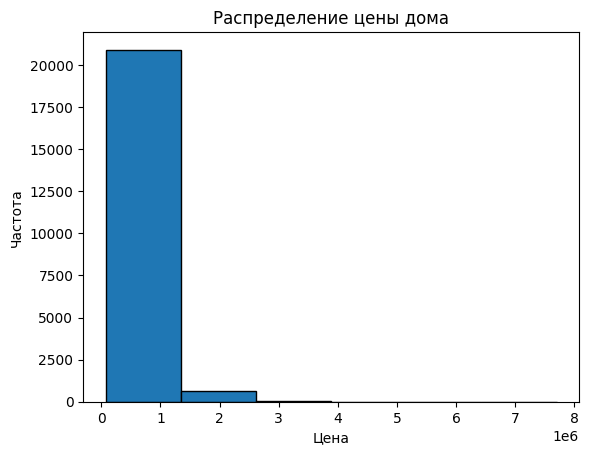

In [4]:
pd.set_option('display.float_format', '{:.2f}'.format)
print('mode:', data_clean['price'].mode())
print(data_clean['price'].describe())
print('skew: ', data_clean['price'].skew())
print('kurtosis: ', data_clean['price'].kurtosis())

plt.hist(data_clean['price'], bins=intervals, edgecolor='black')
plt.title('Распределение цены дома')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

Ассиметрия: 4.024 — сильная правосторонняя асимметрия

Эксцесс: 34.586 — крайне островершинное распределение с тяжёлыми хвостами

Среднее: 540088.14, Медиана: 450000.0 — среднее заметно выше медианы из-за наличия выбросов

В итоге можно сказать что гистограмма распределения сильно смещена вправо, содержит экстремальные значения (выбросы), не соответствует нормальному распределению.


#### Анализ и визуализации для параметра bedrooms (количество спален)

count   21613.00
mean        3.37
std         0.93
min         0.00
25%         3.00
50%         3.00
75%         4.00
max        33.00
Name: bedrooms, dtype: float64
skew:  1.9742995354360104
kurtosis:  49.063653181700985


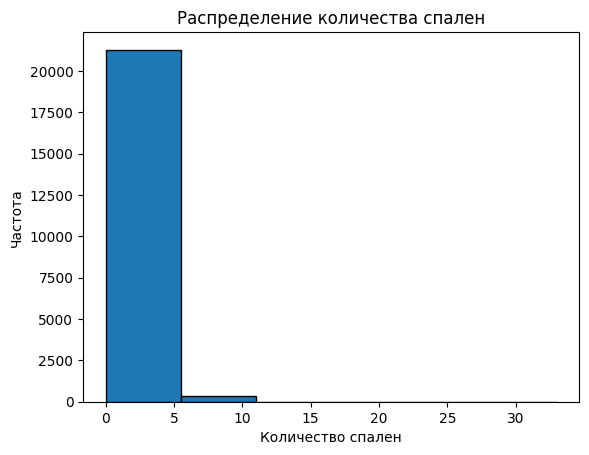

In [5]:
print(data_clean['bedrooms'].describe())
print('skew: ', data_clean['bedrooms'].skew())
print('kurtosis: ', data_clean['bedrooms'].kurtosis())

plt.hist(data_clean['bedrooms'], bins=min(intervals, 20), edgecolor='black')
plt.title('Распределение количества спален')
plt.xlabel('Количество спален')
plt.ylabel('Частота')
plt.show()

#### Анализ и визуализации для параметра bathrooms (количество ванных комнат)

count   21613.00
mean        2.11
std         0.77
min         0.00
25%         1.75
50%         2.25
75%         2.50
max         8.00
Name: bathrooms, dtype: float64
skew:  0.511107573347417
kurtosis:  1.2799024441754527


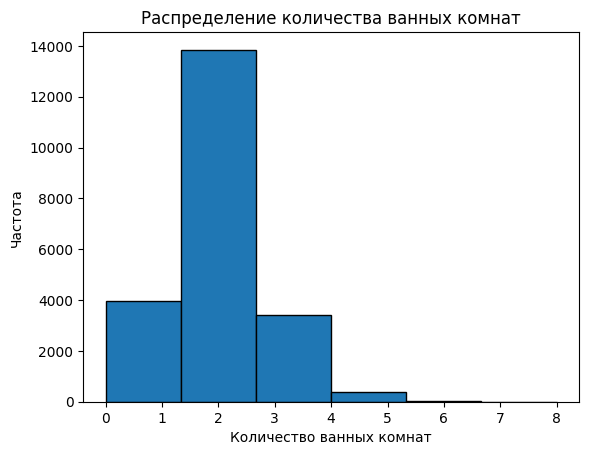

In [6]:
print(data_clean['bathrooms'].describe())
print('skew: ', data_clean['bathrooms'].skew())
print('kurtosis: ', data_clean['bathrooms'].kurtosis())

plt.hist(data_clean['bathrooms'], bins=min(intervals, 30), edgecolor='black')
plt.title('Распределение количества ванных комнат')
plt.xlabel('Количество ванных комнат')
plt.ylabel('Частота')
plt.show()

#### Анализ и визуализации для параметра sqft_living (жилая площадь)

count   21613.00
mean     2079.90
std       918.44
min       290.00
25%      1427.00
50%      1910.00
75%      2550.00
max     13540.00
Name: sqft_living, dtype: float64
skew:  1.471555426802092
kurtosis:  5.243092989817112


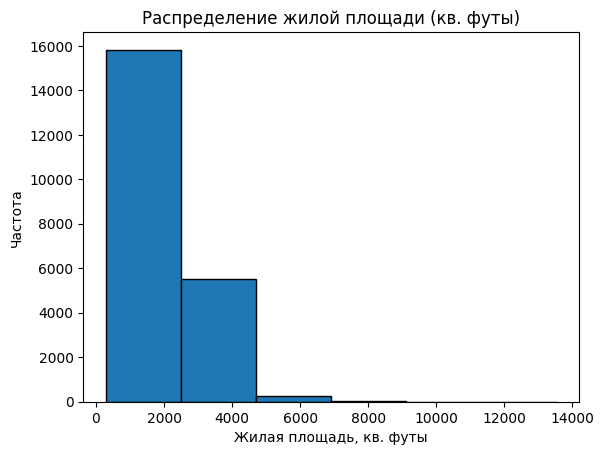

In [7]:
print(data_clean['sqft_living'].describe())
print('skew: ', data_clean['sqft_living'].skew())
print('kurtosis: ', data_clean['sqft_living'].kurtosis())

plt.hist(data_clean['sqft_living'], bins=intervals, edgecolor='black')
plt.title('Распределение жилой площади (кв. футы)')
plt.xlabel('Жилая площадь, кв. футы')
plt.ylabel('Частота')
plt.show()

#### Анализ и визуализации для параметра grade (оценка качества)

count   21613.00
mean        7.66
std         1.18
min         1.00
25%         7.00
50%         7.00
75%         8.00
max        13.00
Name: grade, dtype: float64
skew:  0.7711032007576066
kurtosis:  1.1909320773987666


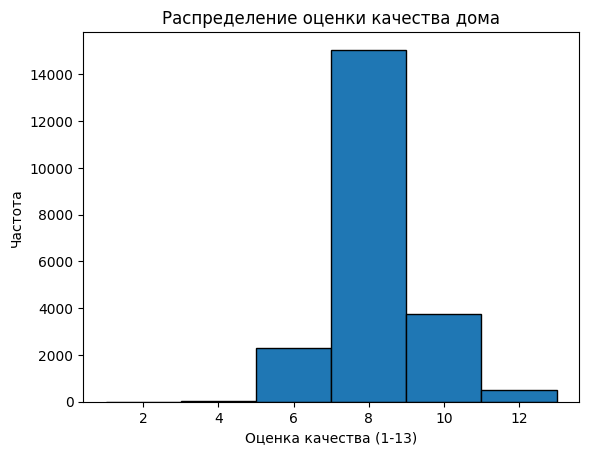

In [8]:
print(data_clean['grade'].describe())
print('skew: ', data_clean['grade'].skew())
print('kurtosis: ', data_clean['grade'].kurtosis())

plt.hist(data_clean['grade'], bins=min(intervals, 13), edgecolor='black')
plt.title('Распределение оценки качества дома')
plt.xlabel('Оценка качества (1-13)')
plt.ylabel('Частота')
plt.show()


### Построение матрицы корреляции
Что такое матрица кореляции  
Матрица корреляции — это таблица, которая показывает насколько сильно и в каком направлении связаны между собой все пары числовых переменных в наборе данных.
- Если есть n числовых признаков X1, X2, .. Xn то матрица будет размером n x n
- На пересечении строки i и столбца j тоит коэффициент корреляции между Xi и Xj
- Диагональ всегда содержит единицы, потому что каждый признак полностью коррелирован сам с собой.   

Коэфициент корреляции Пирсона:   
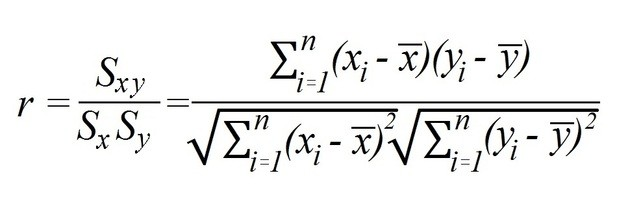

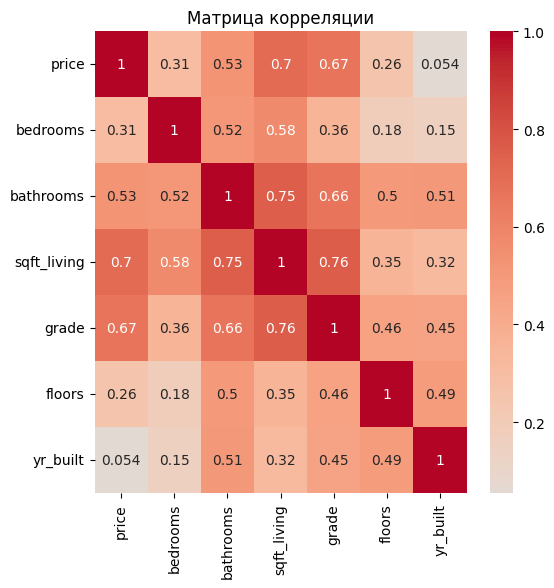

In [9]:
corr_matrix = data_clean.corr()
plt.figure(figsize=(6, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляции')
plt.show()

Видно что цена сильнее всего зависит от жилой площади и общей оценки дома (умеренная и сильная связь). Меньше всего зависит от года постройки и числа этажей.

Сделаем выводы о наличии мультиколлинеарности.
Мультиколлинеарность — это ситуация в регрессионном анализе, когда независимые переменные сильно коррелируют между собой.
Рассчитаем VIF коэффициенты для всех переменных кроме зависимой.

VIF (коэффициент инфляции дисперсии) — это численный показатель, который измеряет насколько дисперсия оцененного коэффициента регрессии увеличивается из-за мультиколлинеарности.  
Рассчитывается так:  
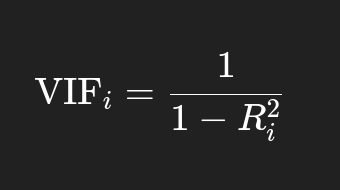

R^2  
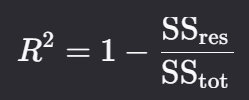

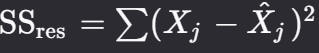

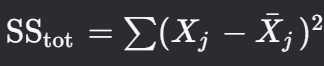

Проведем рассчет значения VIF коэффициента для всех значений, кроме зависимой переменной

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

data_clean = data.dropna()
X = data_clean[['bedrooms','bathrooms', 'sqft_living', 'grade', 'floors', 'yr_built']]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("VIF:")
print(vif_data)

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Создаем PCA, оставим столько компонент, сколько переменных
# pca = PCA(n_components=X.shape[1])
# X_pca = pca.fit_transform(X_scaled)

# # Доля объяснённой дисперсии каждой компоненты
# explained_variance = pca.explained_variance_ratio_
# print("\nДоля объяснённой дисперсии каждой PCA-компоненты:")
# for i, var in enumerate(explained_variance):
#     print(f"PC{i+1}: {var:.4f}")


VIF:
       feature    VIF
0     bedrooms  22.43
1    bathrooms  24.30
2  sqft_living  24.12
3        grade 123.55
4       floors  12.43
5     yr_built  83.96


Практически все переменные сильно коррелируют между собой (VIF > 5).
Использовать их напрямую в линейной регрессии нежелательно, коэффициенты будут нестабильны.

##  Построение регрессионых моделей

Как считаются метрики качества:  
RMSE  
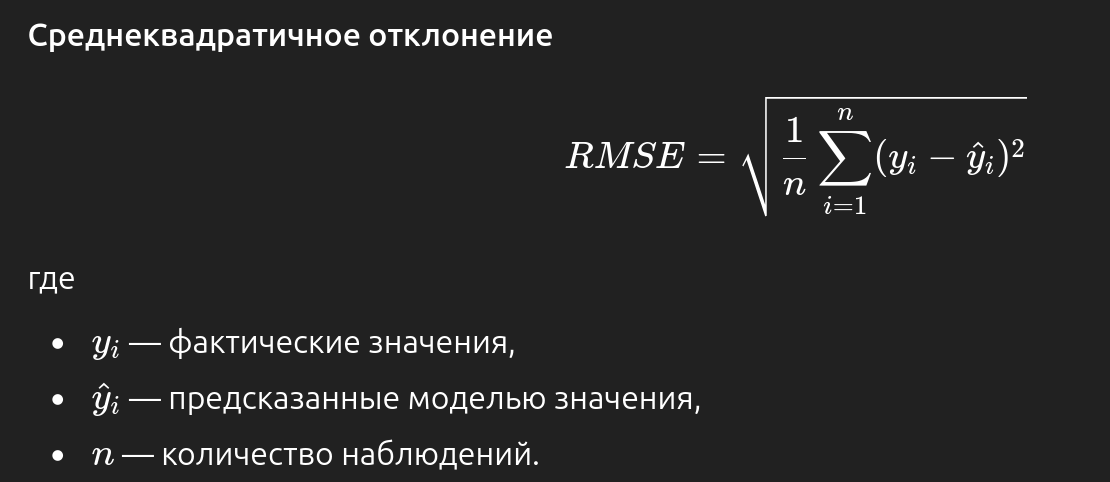

R^2  
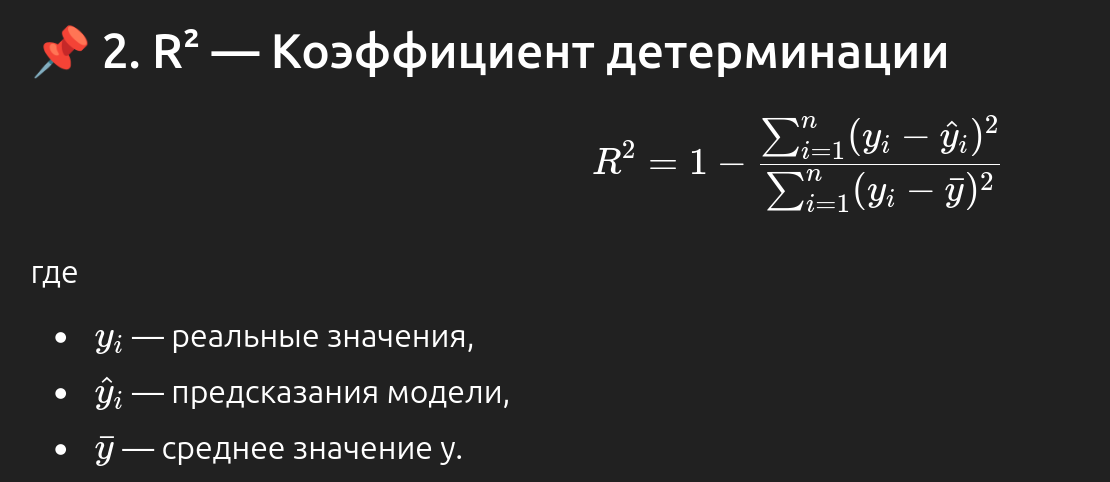

MAPE  
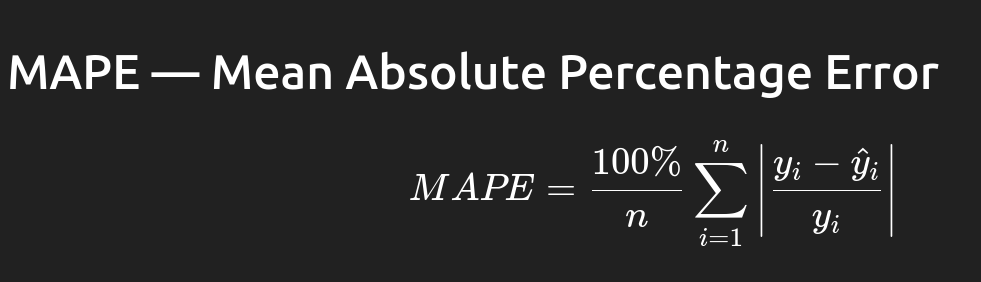

### Линейная регрессионная модель

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

X = data_clean[['bedrooms','bathrooms', 'sqft_living', 'grade', 'floors', 'yr_built']]
y = data_clean['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin_reg = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lin_reg, X_train, y_train, cv=kf, scoring='r2')
print("CV R² scores:", cv_scores)
print("Средний CV R²:", np.mean(cv_scores))

lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)

rmse_line = np.sqrt(mean_squared_error(y_test, y_pred))
r2_line = r2_score(y_test, y_pred)
mape_line = mean_absolute_percentage_error(y_test, y_pred) * 100  # в процентах

print(f"\nРезультаты оценки модели:")
print("-" * 60)
print(f"RMSE (Среднеквадратичная ошибка):      {rmse_line:.4f}")
print(f"R² (Коэффициент детерминации):        {r2_line:.4f}")
print(f"MAPE (Средняя абсолютная ошибка, %):   {mape_line:.4f}%")


CV R² scores: [0.61985016 0.60071114 0.6230298  0.61891189 0.60979705]
Средний CV R²: 0.6144600078296035

Результаты оценки модели:
------------------------------------------------------------
RMSE (Среднеквадратичная ошибка):      243173.6026
R² (Коэффициент детерминации):        0.6088
MAPE (Средняя абсолютная ошибка, %):   30.1155%


### Гребневая регрессия

In [12]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge = Ridge()

param_grid = {'alpha': [0.1, 1, 10, 50, 100, 200]}

grid_search = GridSearchCV(ridge, param_grid, cv=kf, scoring='r2')
grid_search.fit(X_train, y_train)

best_ridge = grid_search.best_estimator_
print("Best alpha:", grid_search.best_params_)

y_pred_ridge = best_ridge.predict(X_test)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)
mape_ridge = mean_absolute_percentage_error(y_test, y_pred_ridge) * 100  # в процентах

print(f"\nРезультаты оценки модели:")
print("-" * 60)
print(f"RMSE (Среднеквадратичная ошибка):      {rmse_ridge:.4f}")
print(f"R² (Коэффициент детерминации):        {r2_ridge:.4f}")
print(f"MAPE (Средняя абсолютная ошибка, %):   {mape_ridge:.4f}%")


Best alpha: {'alpha': 50}

Результаты оценки модели:
------------------------------------------------------------
RMSE (Среднеквадратичная ошибка):      243176.9913
R² (Коэффициент детерминации):        0.6088
MAPE (Средняя абсолютная ошибка, %):   30.1037%


### Анализ полученных данных
R^2: 0.6
Модель объясняет ~ 60% цены.  
Для домов, цены которых могут достигать миллионов, это умеренная ошибка, хотя заметна.  
MAPE: 30.11%
Средняя относительная ошибка ~ 30%
То есть предсказания в среднем отличаются на 30% от реальных цен. Это высокая ошибка
Это показывает, что модель учитывает основную зависимость но сильно варьируются отдельные дома (видимо из-за выбросов и больших цен).  
Полученные значения CV R² scores показывают, что модель дает хорошую стабильность.  
Для гребневой регрессии резульаты почти не отличаются.

### Метод главных компонент (PCA)


Доля объяснённой дисперсии каждой компоненты:
PC1: 0.5702
PC2: 0.1766
PC3: 0.0940
PC4: 0.0852
PC5: 0.0475
PC6: 0.0266

Кумулятивная объяснённая дисперсия:
PC1..PC1: 0.5702
PC1..PC2: 0.7468
PC1..PC3: 0.8408
PC1..PC4: 0.9259
PC1..PC5: 0.9734
PC1..PC6: 1.0000


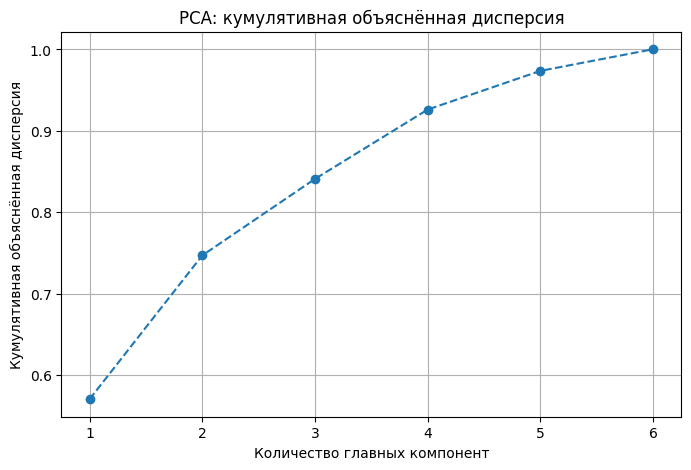


Выбираем 4 компонент для дальнейшей модели (≥90% вариативности)
Форма нового набора признаков после PCA: (21613, 4)


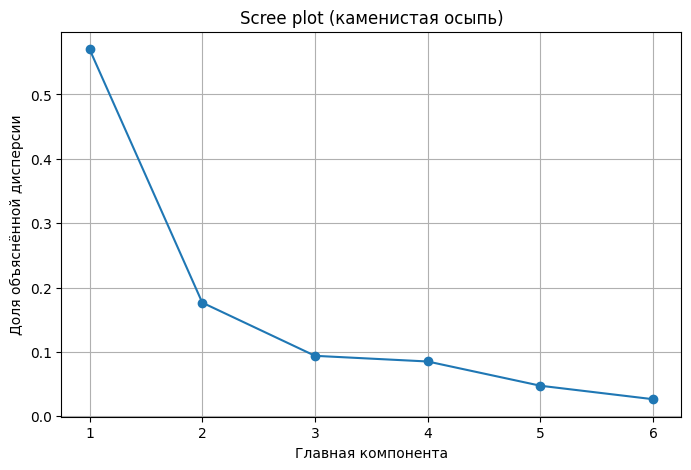


Выбираем 4 компонент для дальнейшей модели (≥90% вариативности)
Форма нового набора признаков после PCA: (21613, 4)


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
data_clean = data.dropna()
X = data_clean[['bedrooms','bathrooms', 'sqft_living', 'grade', 'floors', 'yr_built']]
y = data_clean['price']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("Доля объяснённой дисперсии каждой компоненты:")
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.4f}")

print("\nКумулятивная объяснённая дисперсия:")
for i, cum_var in enumerate(cumulative_variance):
    print(f"PC1..PC{i+1}: {cum_var:.4f}")

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Количество главных компонент')
plt.ylabel('Кумулятивная объяснённая дисперсия')
plt.title('PCA: кумулятивная объяснённая дисперсия')
plt.grid(True)
plt.show()

n_components = np.argmax(cumulative_variance >= 0.90) + 1
print(f"\nВыбираем {n_components} компонент для дальнейшей модели (≥90% вариативности)")

X_pca_reduced = X_pca[:, :n_components]
print("Форма нового набора признаков после PCA:", X_pca_reduced.shape)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance)+1),
         explained_variance, marker='o')
plt.xlabel('Главная компонента')
plt.ylabel('Доля объяснённой дисперсии')
plt.title('Scree plot (каменистая осыпь)')
plt.grid(True)
plt.show()

n_components = np.argmax(cumulative_variance >= 0.90) + 1
print(f"\nВыбираем {n_components} компонент для дальнейшей модели (≥90% вариативности)")

X_pca_reduced = X_pca[:, :n_components]
print("Форма нового набора признаков после PCA:", X_pca_reduced.shape)

Построение регрессионных моделей на главных компонентах

In [14]:
X_pca_reduced = X_pca[:, :n_components]
print(f"Используем {n_components} PCA-компонент для моделей.")

X_train, X_test, y_train, y_test = train_test_split(X_pca_reduced, y, test_size=0.2, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

lin_reg = LinearRegression()
cv_scores = cross_val_score(lin_reg, X_train, y_train, cv=kf, scoring='r2')
print("\nLinear Regression Cross-validation R² scores:", cv_scores)
print("Mean CV R²:", np.mean(cv_scores))

lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

rmse_lin_pca = np.sqrt(mean_squared_error(y_test, y_pred_lin))
r2_line_pca = r2_score(y_test, y_pred_lin)
mape_lin_pca = mean_absolute_percentage_error(y_test, y_pred_lin) * 100

print(f"\nРезультаты оценки модели Linear Regression:")
print("-" * 60)
print(f"RMSE (Среднеквадратичная ошибка):      {rmse_lin_pca:.4f}")
print(f"R² (Коэффициент детерминации):        {r2_line_pca:.4f}")
print(f"MAPE (Средняя абсолютная ошибка, %):   {mape_lin_pca:.4f}%")

ridge = Ridge()
param_grid = {'alpha': [0.1, 1, 10, 50, 100, 200]}
grid_search = GridSearchCV(ridge, param_grid, cv=kf, scoring='r2')
grid_search.fit(X_train, y_train)

best_ridge = grid_search.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)

rmse_ridge_pca = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge_pca = r2_score(y_test, y_pred_ridge)
mape_ridge_pca = mean_absolute_percentage_error(y_test, y_pred_ridge) * 100

print(f"\nРезультаты оценки модели Ridge Regression:")
print("-" * 60)
print(f"RMSE (Среднеквадратичная ошибка):      {rmse_ridge_pca:.4f}")
print(f"R² (Коэффициент детерминации):        {r2_ridge_pca:.4f}")
print(f"MAPE (Средняя абсолютная ошибка, %):   {mape_ridge_pca:.4f}%")

Используем 4 PCA-компонент для моделей.

Linear Regression Cross-validation R² scores: [0.62115959 0.6037383  0.62145193 0.617169   0.61029087]
Mean CV R²: 0.6147619373761077

Результаты оценки модели Linear Regression:
------------------------------------------------------------
RMSE (Среднеквадратичная ошибка):      243468.6083
R² (Коэффициент детерминации):        0.6079
MAPE (Средняя абсолютная ошибка, %):   30.2063%

Результаты оценки модели Ridge Regression:
------------------------------------------------------------
RMSE (Среднеквадратичная ошибка):      243527.3711
R² (Коэффициент детерминации):        0.6077
MAPE (Средняя абсолютная ошибка, %):   30.1383%


### Сравнение моделей

In [15]:
comparison_data = {
    'Модель': [
        'Линейная регрессия (исходные)',
        'Гребневая регрессия (исходные)',
        'Линейная регрессия (PCA)',
        'Гребневая регрессия (PCA)'
    ],
    'RMSE': [
        rmse_line,
        rmse_ridge,
        rmse_lin_pca,
        rmse_ridge_pca
    ],
    'R²': [
        r2_line,
        r2_ridge,
        r2_line_pca,
        r2_ridge_pca
    ],
    'MAPE (%)': [
        mape_line,
        mape_ridge,
        mape_lin_pca,
        mape_ridge_pca
    ],
    'Признаки': [
        '6 исходных',
        '6 исходных',
        f'{X_train.shape[1]} главных компонент',
        f'{X_train.shape[1]} главных компонент'
    ]
}

results_df = pd.DataFrame(comparison_data)

results_df = results_df.sort_values('R²', ascending=False).reset_index(drop=True)

print(results_df.to_string(index=False))


                        Модель      RMSE   R²  MAPE (%)            Признаки
 Линейная регрессия (исходные) 243173.60 0.61     30.12          6 исходных
Гребневая регрессия (исходные) 243176.99 0.61     30.10          6 исходных
      Линейная регрессия (PCA) 243468.61 0.61     30.21 4 главных компонент
     Гребневая регрессия (PCA) 243527.37 0.61     30.14 4 главных компонент


#### Проверка устраненния мультиколлениарности 

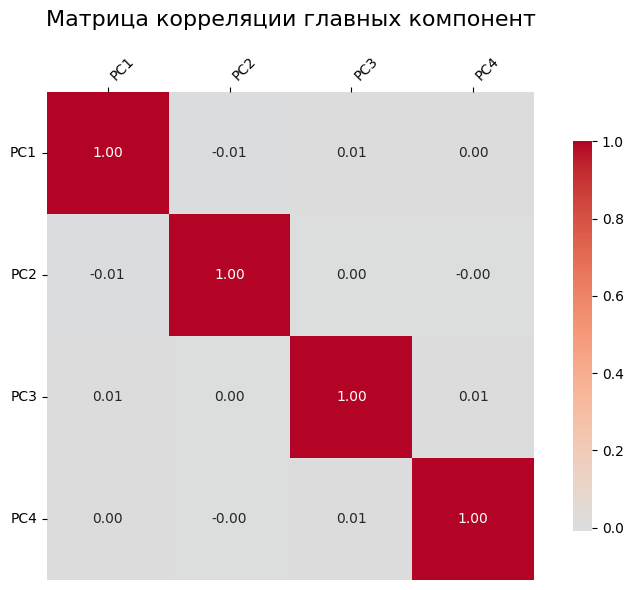

In [16]:
pca_corr_matrix = np.corrcoef(X_train.T)
pca_corr_df = pd.DataFrame(
    pca_corr_matrix,
    columns=[f'PC{i+1}' for i in range(X_train.shape[1])],
    index=[f'PC{i+1}' for i in range(X_train.shape[1])]
)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    pca_corr_df, 
    annot=True,           
    cmap='coolwarm',      
    center=0,             
    square=True,          
    fmt='.2f',            
    cbar_kws={"shrink": .8}
)

plt.title('Матрица корреляции главных компонент', fontsize=16, pad=20)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=45, ha='left')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()




Максимальная корреляция между компонентами очень мала (близка к нулю). Значит, мультиколлинеарность успешно устранена.


## Итоговые выводы
В ходе лабораторной работы были последовательно выполнены все этапы построения и анализа регрессионных моделей. Данные были загружены, очищены и исследованы с точки зрения распределений признаков и их взаимосвязей. Анализ корреляционной матрицы и расчёт коэффициентов VIF показали выраженную мультиколлинеарность между большинством признаков, что делает использование классической линейной регрессии менее надёжным.

Для устранения мультиколлинеарности был применён метод главных компонент (PCA), позволивший существенно снизить коррелированность признаков и при этом сохранить более 90% исходной дисперсии данных. Такой подход уменьшил размерность признакового пространства и устранил линейные зависимости между переменными.

Были построены и оценены две модели — линейная и гребневая регрессия — как на исходных признаках, так и на преобразованных PCA-компонентах. Сравнение метрик (RMSE, R², MAPE) показало, что модели, обученные на исходных данных, продемонстрировали немного более высокое качество по сравнению с моделями, обученными на главных компонентах. Это объясняется небольшими потерями информации, возникающими при использовании PCA, несмотря на высокую сохранённую долю дисперсии.

Тем не менее модели на PCA-компонентах оказались более устойчивыми и лишёнными мультиколлинеарности, а также имеют меньшую вычислительную сложность. Таким образом, применение PCA позволило улучшить интерпретируемость и стабильность регрессионного анализа, что особенно важно при работе с моделями, чувствительными к взаимозависимым признакам.

В целом работа демонстрирует, что устранение мультиколлинеарности и снижение размерности могут улучшить устойчивость регрессионных моделей, однако при этом возможно небольшое ухудшение точности предсказания. Оптимальный выбор подхода зависит от требований к объяснимости, скорости и стабильности модели.